In [660]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import copy

Populating the interactive namespace from numpy and matplotlib


/Users/lackey/Library/Python/2.7/lib/python/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'ndim', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [795]:
import sys

#sys.path.insert(1, '/Users/lackey/src/GPflow/GPflow')
#sys.path.append('/Users/lackey/src/GPflow')

sys.path.insert(0, '../src')
import gaussianprocessregression as gpr
import designofexperiment as doe

In [812]:
import imp

imp.reload(gpr)
imp.reload(doe)

<module 'designofexperiment' from '../src/designofexperiment.pyc'>

# Space filling LHD

In [467]:
navail=5
ndim=2
avail_point_ind = np.random.randint(0, navail, size=ndim)
print avail_point_ind

available_points = np.array([[i]*ndim for i in range(navail)])
print available_points

np.array([available_points[avail_point_ind[i], i] for i in range(ndim)])

[1 1]
[[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]]


array([1, 1])

In [641]:
# Start with list of values for each cordinate
# Pick point at random, then remove those values from list

# Search over as many of the allowed (N-1)^d points as you have time for 
# Calculate the distance from the previous points (or some other objective function).
# Pick the point that maximizes the minimum distance from the previous points

# Repeat for the 3rd point

# This is a greedy method.

def distance(p1, p2):
    ndim = len(p1)
    dist_sq = np.sum(np.array([(p1[i]-p2[i])**2 for i in range(ndim)]))
    return np.sqrt(dist_sq)

def projected_distance_2d(p1, p2, i, j):
    """
    """
    return np.sqrt((p1[i]-p2[i])**2 + (p1[j]-p2[j])**2)

def min_projected_distance_2d(p1, p2):
    """The minimum of the projected 2d distance taken over all combinations of parameters.
    """
    ndim = len(p1)
    dist_list = []
    for i in range(ndim-1):
        for j in range(i+1, ndim):
            dist = projected_distance_2d(p1, p2, i, j)
            dist_list.append(dist)
            
    return np.min(np.array(dist_list))
    
class MaxiMinLHD(object):
    def __init__(self, npoints, ndim):
        """Latin Hypercube Design which attempts to 
        maximize the minimum distance between points.
        """
        self.npoints = npoints
        self.ndim = ndim
        
        # Coordinates in each dimension that can still be used to choose a new point.
        self.available_points = np.array([[i]*self.ndim for i in range(self.npoints)])
        
        # Points that have been chosen for the LHD.
        self.chosen_points = None

    def sample_new_point(self):
        """Randomly select a point from the allowed points. 
        """
        navail = len(self.available_points)
        
        # Randomly pick the index of the coordinate for each column 
        avail_point_ind = np.random.randint(0, navail, size=self.ndim)
        
        # Sample the new point
        new_point = np.array([self.available_points[avail_point_ind[i], i] for i in range(self.ndim)])
        return new_point
    
    def set_new_point(self, new_point):
        """Update the chosen points new_point. 
        """
        # Append new point to chosen_points
        if self.chosen_points is None:
            self.chosen_points = np.atleast_2d(new_point)
        else:
            self.chosen_points = np.concatenate((self.chosen_points, np.atleast_2d(new_point)))
        
        # Remove new point from available_points
        new_avail = []
        for i in range(self.ndim):
            col = self.available_points[:, i]
            j_del = numpy.where(col==new_point[i])
            col = np.delete(col, j_del)
            new_avail.append(col)
            
        self.available_points = np.array(new_avail).T
    
    def minimum_distance(self, point):
        """Find the minimum distance between point and the chosen_points.
        """
        nchosen = len(self.chosen_points)
        return np.min(np.array([distance(point, self.chosen_points[i]) for i in range(nchosen)]))
    
    def find_next_maximin(self, ntry):
        """Search for a new point that has the farthest distance from the already chosen_points.
        Randomly select ntry available_points.
        """
        points = np.array([self.sample_new_point() for i in range(ntry)])
        min_dist = np.array([self.minimum_distance(points[i]) for i in range(ntry)])
        imax = np.argmax(min_dist)
        return points[imax]
    
    def minimum_2d_distance(self, point):
        nchosen = len(self.chosen_points)
        return np.min(np.array([min_projected_distance_2d(point, self.chosen_points[i]) for i in range(nchosen)]))
    
    def find_next_2d_maximin(self, ntry):
        points = np.array([self.sample_new_point() for i in range(ntry)])
        min_dist = np.array([self.minimum_2d_distance(points[i]) for i in range(ntry)])
        imax = np.argmax(min_dist)
        return points[imax]
    
    def rescale(self, limits):
        """Rescale each dimension from [0, npoints-1] to [xlow, xhigh].
        """
        rescaled = []
        for i in range(ndim):
            xlow, xhigh = limits[i, 0], limits[i, 1]
            slope = float(xhigh-xlow)/float(npoints-1)
            rescaled_i = np.array([xlow+slope*j for j in range(npoints)])
            rescaled.append(rescaled_i)
            
        return np.array(rescaled).T

In [642]:
npoints = 5
ndim=2
lhd = MaxiMinLHD(npoints, ndim)
print lhd.npoints, lhd.ndim
print lhd.available_points
print lhd.chosen_points

5 2
[[0 0]
 [1 1]
 [2 2]
 [3 3]
 [4 4]]
None


In [643]:
p = lhd.sample_new_point()
print p

lhd.set_new_point(p)
print lhd.npoints, lhd.ndim
print lhd.available_points
print lhd.chosen_points

[3 2]
5 2
[[0 0]
 [1 1]
 [2 3]
 [4 4]]
[[3 2]]


In [644]:
p = lhd.sample_new_point()
print lhd.minimum_distance(p)

ntry = 10
pmax = lhd.find_next_maximin(ntry)
print lhd.minimum_distance(pmax)

2.2360679775
3.60555127546


In [645]:
p1 = np.array([2.99, 5, 6.99])
p2 = np.array([3, 4.9, 7])
print distance(p1, p2)
print min_projected_distance_2d(p1, p2)

0.100995049384
0.0141421356237


In [733]:
def generate_lhd(npoints, ndim):
    lhd = MaxiMinLHD(npoints, ndim)
    for i in range(npoints):
        p = lhd.sample_new_point()
        lhd.set_new_point(p)
    
    return lhd

def generate_maximin_lhd(npoints, ndim, ntry):
    lhd = MaxiMinLHD(npoints, ndim)
    
    # Set first point
    p = lhd.sample_new_point()
    lhd.set_new_point(p)
    
    # Set the next npoints-1
    for i in range(npoints-1):
        p = lhd.find_next_maximin(ntry)
        lhd.set_new_point(p)
    
    return lhd

def generate_maximin_2d_lhd(npoints, ndim, ntry):
    lhd = MaxiMinLHD(npoints, ndim)
    
    # Set first point
    p = lhd.sample_new_point()
    lhd.set_new_point(p)
    
    # Set the next npoints-1
    for i in range(npoints-1):
        p = lhd.find_next_2d_maximin(ntry)
        lhd.set_new_point(p)
    
    return lhd

def all_distances(lhd):
    """Calculate all npoints*(npoints-1)/2 pairwise distances.
    """
    ps = lhd.chosen_points
    npoints = len(ps)
    ds = [[distance(ps[i], ps[j]) for j in range(i+1, npoints)] for i in range(npoints-1)]
    flatten = lambda l: [item for sublist in l for item in sublist]
    dsflat = flatten(ds)
    return np.array(dsflat)

def all_distances_2d(lhd):
    """Calculate all npoints*(npoints-1)/2 pairwise distances.
    """
    ps = lhd.chosen_points
    npoints = len(ps)
    ds = [[min_projected_distance_2d(ps[i], ps[j]) for j in range(i+1, npoints)] for i in range(npoints-1)]
    flatten = lambda l: [item for sublist in l for item in sublist]
    dsflat = flatten(ds)
    return np.array(dsflat)


def phi(lhd, p=2):
    ds = all_distances(lhd)
    ds_invp = ds**(-p)
    return np.sum(ds_invp)**(1.0/p)

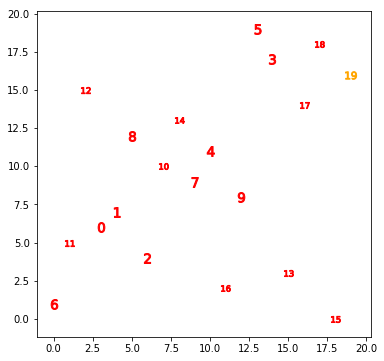

In [752]:
def lhd_minimize_energy(npoints, ndim, ntry):
    lhd_best = None
    min_energy = np.infty
    for i in range(ntry):
        lhd = generate_lhd(npoints, ndim)
        energy = phi(lhd, p=2)
        
        if energy < min_energy:
            lhd_best = lhd
            min_energy = energy
        
    return lhd


npoints = 20
ndim = 5
ntry = 100
lhd = lhd_minimize_energy(npoints, ndim, ntry)

fig, axes = plt.subplots(1, figsize=(6, 6))
plot_numbered_points(axes, lhd.chosen_points)

In [670]:
npoints = 20
ndim=5
ntry=1000
limits = limits = np.array([[-5, 10], [0, 20], [13.2, 30], [4, 40], [-7.6, 50.5]])


lhd = MaxiMinLHD(npoints, ndim)

# Set first point
p = lhd.sample_new_point()
lhd.set_new_point(p)

# Set the next npoints-1
for i in range(npoints-1):
    p = lhd.find_next_maximin(ntry)
    lhd.set_new_point(p)

#lhd.rescale(limits)

In [704]:
npoints = 20
ndim=5
#limits = limits = np.array([[-5, 10], [0, 20], [13.2, 30], [4, 40], [-7.6, 50.5]])


lhd = MaxiMinLHD(npoints, ndim)
for i in range(npoints):
    p = lhd.sample_new_point()
    lhd.set_new_point(p)
    
all_distances(lhd).min()

6.4031242374328485

0.782355687784


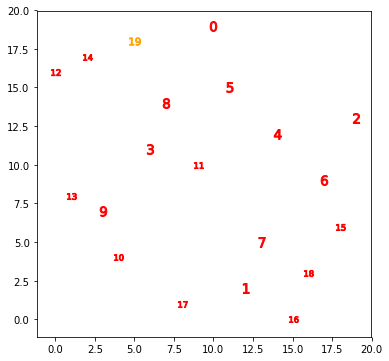

In [753]:
npoints = 20
ndim=5

lhd_best = None
maximin_dist = 0.0
for i in range(1):
    lhd = generate_lhd(npoints, ndim)
    #min_dist = all_distances(lhd).min()
    #min_dist = all_distances_2d(lhd).min()
    min_dist = phi(lhd, p=2)
    
    if min_dist > maximin_dist:
        lhd_best = lhd
        maximin_dist = min_dist
        
print maximin_dist**2
fig, axes = plt.subplots(1, figsize=(6, 6))
plot_numbered_points(axes, lhd.chosen_points)

In [751]:
ntry

1000

In [671]:
all_distances(lhd).shape, 20*19/2.

((190,), 190.0)

2.8284271247461903

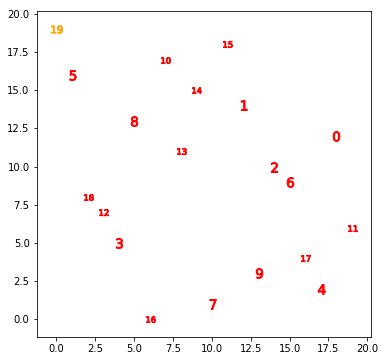

In [679]:
npoints = 20
ndim=5
points = generate_lhd(npoints, ndim)
#print points

fig, axes = plt.subplots(1, figsize=(6, 6))
plot_numbered_points(axes, points)
all_distances(lhd).min()

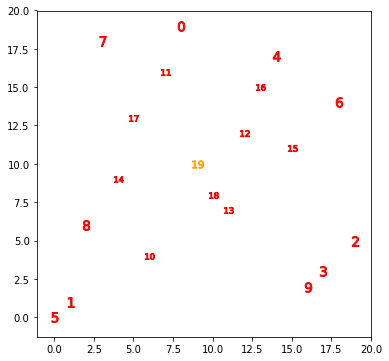

In [638]:
npoints = 20
ndim=5
ntry=1000
points = generate_maximin_lhd(npoints, ndim, ntry)
#print points

fig, axes = plt.subplots(1, figsize=(6, 6))
plot_numbered_points(axes, points)

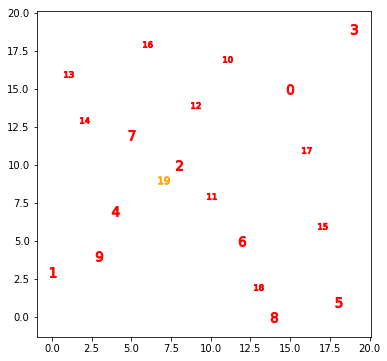

In [630]:
npoints = 20
ndim=5
ntry=1000
points = generate_maximin_2d_lhd(npoints, ndim, ntry)
#print points

fig, axes = plt.subplots(1, figsize=(6, 6))
plot_numbered_points(axes, points)

# Plotting functions and diagnostics

In [849]:
def plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, 
                 interpolation='bicubic', colorbar=True, colorbar_label='z'):
    """Generate a heatmap from the function func.
    """
    # Generate 2d array of z-values
    xs = np.linspace(xlow, xhigh, nx)
    ys = np.linspace(ylow, yhigh, ny)
    zgrid = np.array([[func(x, y) for y in ys] for x in xs])
    
    # Make the plot
    extent = [xs[0], xs[-1], ys[0], ys[-1]]
    im = axes.imshow(zgrid.T, interpolation=interpolation, origin='lower', 
                 extent=extent, aspect='auto')
    
    # Make the colorbar
    if colorbar:
        cb = plt.colorbar(mappable=im, ax=axes)
        cb.set_label(label=colorbar_label)
        
        
def plot_numbered_points(axes, points):
    """
    """
    for i in range(len(points)-1):
        axes.scatter(points[i, 0], points[i, 1], marker='$'+str(i)+'$', s=100, color='r')
        
    axes.scatter(points[-1, 0], points[-1, 1], marker='$'+str(len(points)-1)+'$', s=150, color='orange')
    

def maximum_error(func, gp, limits, error_type='absolute', nsample=100000):
    """
    """
    vps = doe.uniform_random_samples(nsample, limits)

    vps_true = np.array([func(p) for p in vps])
    vps_gp, ysigma = gp.predict(vps, return_std=True)
    
    func_range = np.max(vps_true) - np.min(vps_true)
    #print func_range
    
    if error_type == 'absolute':
        return np.max(np.abs(vps_gp - vps_true))
    elif error_type == 'fractional':
        # Relative error. Not meaningful if the function passes through zero.
        return np.max(np.abs(vps_gp/vps_true - 1.0))
    elif error_type == 'fractional_full_range':
        # Calculate the error relative to the full range of values
        return np.max(np.abs(vps_gp - vps_true)) / func_range
    else:
        raise Exception, "Options for error_type are: 'absolute', 'fractional', 'fractional_full_range'."

# Test the adaptive sampling
## Make and plot the function with the initial LHD samples

In [833]:
def func(x, y):
    return (np.sin(x*(1.0+0.05*x)) + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y

# def func(x, y):
#     return (2.0*np.sin(0.5*x*(1.0+0.05*x)) - 0.3*(x-5.0)**2 + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y

# def func(x, y):
#     if y>0:
#         return (2.0*np.sin(0.5*x*(1.0+0.05*x)) - 0.3*(x-5.0)**2 + 0.5*x + 10)*0.01*(y-5.0)**2 - 0.1*x*y
#     else:
#         return 10.0

# def func(x, y):
#     return (2.0*np.sin(0.5*x*(1.0+0.05*x)) - 0.3*(x-5.0)**2 + 0.5*x + 10)*0.01*(np.abs(y)-5.0)**2 - 0.1*x*np.abs(y)

In [834]:
# ******* Generate the initial points *******
npoints = 20
limits = np.array([[-9.4, 5.], [-2., 2.]])
points = doe.latin_hypercube(npoints, limits)

# ******* Generate data at the initial points *******
npoints = len(points)
data = np.array([func(points[i, 0], points[i, 1]) for i in range(npoints)])

# # ******* Add random noise *******
# sigma = 1.0e-5
# data += np.random.normal(0.0, sigma, len(data))

data.min(), data.max()

(0.39654801353971236, 5.3676164396461017)

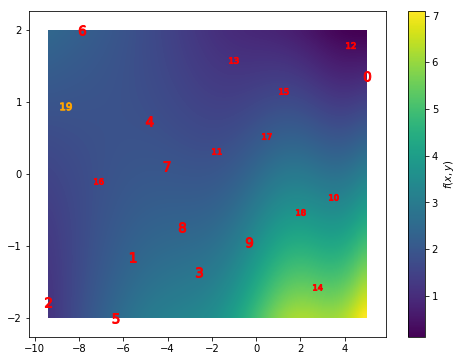

In [835]:
fig, axes = plt.subplots(1, figsize=(8, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50
plot_2d_func(axes, func, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$f(x, y)$')
plot_numbered_points(axes, points)

## Generate initial GPR with the LHD samples
### Don't let the bounds on the lengthscale hyperparameters be too much larger than the size of the parameter space
### or the bounds on sigma_f be too much larger than the range if z=f(x, y)

In [836]:
hp0 = np.array([5.0, 10.0, 10.0, 1.0e-8])
hyper_limits = np.array([[1.0, 10.0], [1.0, 25.0], [1.0, 8.0], [1.0e-9, 1.0e-7]])

#kernel_type = 'matern32'
kernel_type = 'matern52'
#kernel_type = 'squaredexponential'

gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                 hyper_limits=hyper_limits, n_restarts_optimizer=9)
print gp.kernel_

3.61**2 * Matern(length_scale=[8.92, 8], nu=2.5) + WhiteKernel(noise_level=3.86e-16)


1.51624543349
1.20139483701
0.21890691667


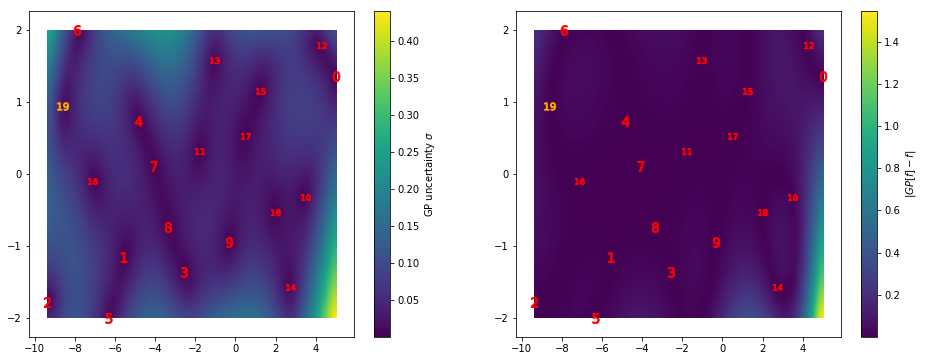

In [851]:
def func_tuple(p):
    return func(p[0], p[1])
print maximum_error(func_tuple, gp, limits, error_type='absolute', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional', nsample=100000)
print maximum_error(func_tuple, gp, limits, error_type='fractional_full_range', nsample=100000)

def gp_predict_error(x, y):
    return gp.predict(np.array([[x, y]]), return_std=True)[1][0]

def true_abs_error(x, y):
    return np.abs(gp.predict(np.array([[x, y]]))[0] - func(x, y))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
xlow, xhigh, nx = limits[0, 0], limits[0, 1], 50
ylow, yhigh, ny = limits[1, 0], limits[1, 1], 50

plot_2d_func(ax1, gp_predict_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'GP uncertainty $\sigma$')
plot_numbered_points(ax1, points)

plot_2d_func(ax2, true_abs_error, xlow, xhigh, nx, ylow, yhigh, ny, colorbar_label=r'$|GP[f]-f|$')
plot_numbered_points(ax2, points)

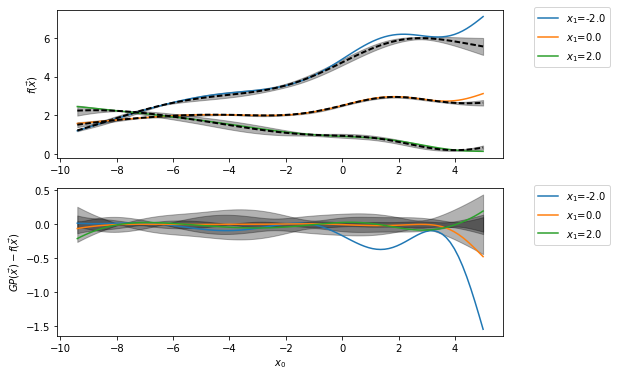

In [852]:
fig, ax = plt.subplots(2, figsize=(8, 6))
for y in np.linspace(limits[1, 0], limits[1, 1], 3):
    xs = np.linspace(limits[0, 0], limits[0, 1], 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(xs, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(xs, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    ax[1].plot(xs, (y_pred-true), label=r'$x_1$='+str(y))
    ax[1].fill_between(xs, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Junk

In [ ]:
https://github.com/fmder/pynolh

In [756]:
import argparse
import math

import numpy

def nolh(conf, remove=None):
    """Constructs a Nearly Orthogonal Latin Hypercube (NOLH) of order *m* from
    a configuration vector *conf*. The configuration vector may contain either
    the numbers in $[0 q-1]$ or $[1 q]$ where $q = 2^{m-1}$. The columns to be
    *removed* are also in $[0 d-1]$ or $[1 d]$ where $d = m + \binom{m-1}{2}$
    is the NOLH dimensionality.
    """
    I = numpy.identity(2, dtype=int)
    R = numpy.array(((0, 1),
                     (1, 0)), dtype=int)

    if 0 in conf:
        conf = numpy.array(conf) + 1

        if remove is not None:
            remove = numpy.array(remove) + 1


    q = len(conf)
    m = math.log(q, 2) + 1
    s = m + (math.factorial(m - 1) / (2 * math.factorial(m - 3)))
    # Factorial checks if m is an integer
    m = int(m)

    A = numpy.zeros((q, q, m - 1), dtype=int)
    for i in range(1, m):
        Ai = 1
        for j in range(1, m):
            if j < m - i:
                Ai = numpy.kron(Ai, I)
            else:
                Ai = numpy.kron(Ai, R)

        A[:, :, i-1] = Ai
    
    M = numpy.zeros((q, s), dtype=int)
    M[:, 0] = conf
    
    col = 1
    for i in range(0, m - 1):
        for j in range(i + 1, m):
            if i == 0:
                M[:, col] = numpy.dot(A[:, :, j-1], conf)
            else:
                M[:, col] = numpy.dot(A[:, :, i-1], numpy.dot(A[:, :, j-1], conf))
            col += 1

    S = numpy.ones((q, s), dtype=int)
    v = 1
    for i in range(1, m):
        for j in range(0, q):
            if j % 2**(i-1) == 0:
                v *= -1
            S[j, i] = v

    col = m
    for i in range(1, m - 1):
        for j in range(i + 1, m):
            S[:, col] = S[:, i] * S[:, j]
            col += 1

    T = M * S
    
    keep = numpy.ones(s, dtype=bool)
    if remove is not None:
        keep[numpy.array(remove) - 1] = [False] * len(remove)
    
    return (numpy.concatenate((T, numpy.zeros((1, s)), -T), axis=0)[:, keep] + 8) / (2.0 * q)

def params(dim):
    """Returns the NOLH order $m$, the required configuration length $q$
    and the number of columns to remove to obtain the desired dimensionality.
    """
    m = 3
    s = 3
    q = 2**(m-1)
    
    while s < dim:
        m += 1
        s = m + math.factorial(m - 1) / (2 * math.factorial(m - 3))
        q = 2**(m-1)

    return m, q, s - dim

# Permutation and columns to remove given by Cioppa
C_CONF = {
    2 : ([1, 2, 8, 4, 5, 6, 7, 3], [1, 3, 4, 6, 7]),
    3 : ([1, 2, 8, 4, 5, 6, 7, 3], [1, 2, 3, 6]),
    4 : ([1, 2, 8, 4, 5, 6, 7, 3], [1, 3, 6]),
    5 : ([1, 2, 8, 4, 5, 6, 7, 3], [1, 6]),
    6 : ([1, 2, 8, 4, 5, 6, 7, 3], [1]),
    7 : ([1, 2, 8, 4, 5, 6, 7, 3], [])
}

# Permutation and columns to remove given by De Rainville et al.
EA_CONF = {
    8  : ([4, 14, 1, 2, 16, 13, 5, 8, 12, 9, 6, 7, 11, 3, 15, 10], [1, 3, 10]),
    9  : ([4, 14, 1, 2, 16, 13, 5, 8, 12, 9, 6, 7, 11, 3, 15, 10], [6, 10]),
    10 : ([4, 14, 1, 2, 16, 13, 5, 8, 12, 9, 6, 7, 11, 3, 15, 10], [10]),
    11 : ([4, 14, 1, 2, 16, 13, 5, 8, 12, 9, 6, 7, 11, 3, 15, 10], []),
    
    12 : ([5, 13, 19, 23, 28, 10, 12, 32, 17, 2, 30, 15, 6, 31, 21, 8, 24,
           29, 9, 14, 11, 22, 18, 25, 3, 1, 20, 7, 27, 16, 26, 4], [2, 4, 5, 11]),
    13 : ([5, 13, 19, 23, 28, 10, 12, 32, 17, 2, 30, 15, 6, 31, 21, 8, 24,
           29, 9, 14, 11, 22, 18, 25, 3, 1, 20, 7, 27, 16, 26, 4], [3, 6, 14]),
    14 : ([5, 13, 19, 23, 28, 10, 12, 32, 17, 2, 30, 15, 6, 31, 21, 8, 24,
           29, 9, 14, 11, 22, 18, 25, 3, 1, 20, 7, 27, 16, 26, 4], [4, 5]),
    15 : ([5, 13, 19, 23, 28, 10, 12, 32, 17, 2, 30, 15, 6, 31, 21, 8, 24,
           29, 9, 14, 11, 22, 18, 25, 3, 1, 20, 7, 27, 16, 26, 4], [6]),
    16 : ([5, 13, 19, 23, 28, 10, 12, 32, 17, 2, 30, 15, 6, 31, 21, 8, 24,
           29, 9, 14, 11, 22, 18, 25, 3, 1, 20, 7, 27, 16, 26, 4], []),
    
    17 : ([7, 8, 51, 3, 40, 44, 29, 19, 61, 43, 26, 48, 20, 52, 4, 49, 2,
           57, 31, 30, 24, 23, 56, 50, 18, 59, 63, 37, 38, 21, 54, 9, 46,
           27, 36, 1, 10, 42, 13, 55, 15, 25, 22, 45, 41, 39, 53, 34, 6, 5,
           2, 58, 16, 28, 64, 14, 47, 33, 12, 35, 62, 17, 11, 60], [8, 11, 12, 14, 17]),
    18 : ([7, 8, 51, 3, 40, 44, 29, 19, 61, 43, 26, 48, 20, 52, 4, 49, 2,
           57, 31, 30, 24, 23, 56, 50, 18, 59, 63, 37, 38, 21, 54, 9, 46,
           27, 36, 1, 10, 42, 13, 55, 15, 25, 22, 45, 41, 39, 53, 34, 6, 5,
           2, 58, 16, 28, 64, 14, 47, 33, 12, 35, 62, 17, 11, 60], [8, 11, 12, 17]),
    19 : ([7, 8, 51, 3, 40, 44, 29, 19, 61, 43, 26, 48, 20, 52, 4, 49, 2,
           57, 31, 30, 24, 23, 56, 50, 18, 59, 63, 37, 38, 21, 54, 9, 46,
           27, 36, 1, 10, 42, 13, 55, 15, 25, 22, 45, 41, 39, 53, 34, 6, 5,
           2, 58, 16, 28, 64, 14, 47, 33, 12, 35, 62, 17, 11, 60], [10, 15, 22]),
    20 : ([7, 8, 51, 3, 40, 44, 29, 19, 61, 43, 26, 48, 20, 52, 4, 49, 2,
           57, 31, 30, 24, 23, 56, 50, 18, 59, 63, 37, 38, 21, 54, 9, 46,
           27, 36, 1, 10, 42, 13, 55, 15, 25, 22, 45, 41, 39, 53, 34, 6, 5,
           2, 58, 16, 28, 64, 14, 47, 33, 12, 35, 62, 17, 11, 60], [8, 12]),
    21 : ([7, 8, 51, 3, 40, 44, 29, 19, 61, 43, 26, 48, 20, 52, 4, 49, 2,
           57, 31, 30, 24, 23, 56, 50, 18, 59, 63, 37, 38, 21, 54, 9, 46,
           27, 36, 1, 10, 42, 13, 55, 15, 25, 22, 45, 41, 39, 53, 34, 6, 5,
           2, 58, 16, 28, 64, 14, 47, 33, 12, 35, 62, 17, 11, 60], [15]),
    22 : ([7, 8, 51, 3, 40, 44, 29, 19, 61, 43, 26, 48, 20, 52, 4, 49, 2,
           57, 31, 30, 24, 23, 56, 50, 18, 59, 63, 37, 38, 21, 54, 9, 46,
           27, 36, 1, 10, 42, 13, 55, 15, 25, 22, 45, 41, 39, 53, 34, 6, 5,
           2, 58, 16, 28, 64, 14, 47, 33, 12, 35, 62, 17, 11, 60], []),

    23 : ([9, 108, 39, 107, 62, 86, 110, 119, 46, 43, 103, 71, 123, 91, 10,
           13, 126, 63, 83, 47, 100, 54, 23, 16, 124, 45, 27, 4, 93, 74, 76,
           90, 30, 81, 77, 53, 116, 49, 104, 6, 70, 82, 26, 118, 55, 79, 32,
           109, 57, 31, 22, 101, 44, 87, 121, 7, 37, 56, 89, 115, 25, 92,
           85, 20, 58, 52, 3, 11, 106, 17, 117, 38, 78, 28, 59, 96, 18, 97,
           50, 114, 112, 60, 84, 1, 12, 61, 98, 128, 14, 42, 64, 105, 68,
           75, 111, 34, 141, 65, 99, 2, 19, 33, 35, 94, 51, 122, 127, 36,
           125, 80, 73, 8, 24, 21, 88, 48, 69, 66, 40, 15, 29, 113, 72, 5,
           95, 120, 6, 102], [18, 20, 21, 24, 27, 29]),
    24 : ([9, 108, 39, 107, 62, 86, 110, 119, 46, 43, 103, 71, 123, 91, 10,
           13, 126, 63, 83, 47, 100, 54, 23, 16, 124, 45, 27, 4, 93, 74, 76,
           90, 30, 81, 77, 53, 116, 49, 104, 6, 70, 82, 26, 118, 55, 79, 32,
           109, 57, 31, 22, 101, 44, 87, 121, 7, 37, 56, 89, 115, 25, 92,
           85, 20, 58, 52, 3, 11, 106, 17, 117, 38, 78, 28, 59, 96, 18, 97,
           50, 114, 112, 60, 84, 1, 12, 61, 98, 128, 14, 42, 64, 105, 68,
           75, 111, 34, 141, 65, 99, 2, 19, 33, 35, 94, 51, 122, 127, 36,
           125, 80, 73, 8, 24, 21, 88, 48, 69, 66, 40, 15, 29, 113, 72, 5,
           95, 120, 6, 102], [4, 15, 18, 24, 27]),
    25 : ([9, 108, 39, 107, 62, 86, 110, 119, 46, 43, 103, 71, 123, 91, 10,
           13, 126, 63, 83, 47, 100, 54, 23, 16, 124, 45, 27, 4, 93, 74, 76,
           90, 30, 81, 77, 53, 116, 49, 104, 6, 70, 82, 26, 118, 55, 79, 32,
           109, 57, 31, 22, 101, 44, 87, 121, 7, 37, 56, 89, 115, 25, 92,
           85, 20, 58, 52, 3, 11, 106, 17, 117, 38, 78, 28, 59, 96, 18, 97,
           50, 114, 112, 60, 84, 1, 12, 61, 98, 128, 14, 42, 64, 105, 68,
           75, 111, 34, 141, 65, 99, 2, 19, 33, 35, 94, 51, 122, 127, 36,
           125, 80, 73, 8, 24, 21, 88, 48, 69, 66, 40, 15, 29, 113, 72, 5,
           95, 120, 6, 102], [21, 26, 27, 29]),
    26 : ([9, 108, 39, 107, 62, 86, 110, 119, 46, 43, 103, 71, 123, 91, 10,
           13, 126, 63, 83, 47, 100, 54, 23, 16, 124, 45, 27, 4, 93, 74, 76,
           90, 30, 81, 77, 53, 116, 49, 104, 6, 70, 82, 26, 118, 55, 79, 32,
           109, 57, 31, 22, 101, 44, 87, 121, 7, 37, 56, 89, 115, 25, 92,
           85, 20, 58, 52, 3, 11, 106, 17, 117, 38, 78, 28, 59, 96, 18, 97,
           50, 114, 112, 60, 84, 1, 12, 61, 98, 128, 14, 42, 64, 105, 68,
           75, 111, 34, 141, 65, 99, 2, 19, 33, 35, 94, 51, 122, 127, 36,
           125, 80, 73, 8, 24, 21, 88, 48, 69, 66, 40, 15, 29, 113, 72, 5,
           95, 120, 6, 102], [26, 27, 29]),
    27 : ([9, 108, 39, 107, 62, 86, 110, 119, 46, 43, 103, 71, 123, 91, 10,
           13, 126, 63, 83, 47, 100, 54, 23, 16, 124, 45, 27, 4, 93, 74, 76,
           90, 30, 81, 77, 53, 116, 49, 104, 6, 70, 82, 26, 118, 55, 79, 32,
           109, 57, 31, 22, 101, 44, 87, 121, 7, 37, 56, 89, 115, 25, 92,
           85, 20, 58, 52, 3, 11, 106, 17, 117, 38, 78, 28, 59, 96, 18, 97,
           50, 114, 112, 60, 84, 1, 12, 61, 98, 128, 14, 42, 64, 105, 68,
           75, 111, 34, 141, 65, 99, 2, 19, 33, 35, 94, 51, 122, 127, 36,
           125, 80, 73, 8, 24, 21, 88, 48, 69, 66, 40, 15, 29, 113, 72, 5,
           95, 120, 6, 102], [27, 29]),
    28 : ([9, 108, 39, 107, 62, 86, 110, 119, 46, 43, 103, 71, 123, 91, 10,
           13, 126, 63, 83, 47, 100, 54, 23, 16, 124, 45, 27, 4, 93, 74, 76,
           90, 30, 81, 77, 53, 116, 49, 104, 6, 70, 82, 26, 118, 55, 79, 32,
           109, 57, 31, 22, 101, 44, 87, 121, 7, 37, 56, 89, 115, 25, 92,
           85, 20, 58, 52, 3, 11, 106, 17, 117, 38, 78, 28, 59, 96, 18, 97,
           50, 114, 112, 60, 84, 1, 12, 61, 98, 128, 14, 42, 64, 105, 68,
           75, 111, 34, 141, 65, 99, 2, 19, 33, 35, 94, 51, 122, 127, 36,
           125, 80, 73, 8, 24, 21, 88, 48, 69, 66, 40, 15, 29, 113, 72, 5,
           95, 120, 6, 102], [20]),
    29 : ([9, 108, 39, 107, 62, 86, 110, 119, 46, 43, 103, 71, 123, 91, 10,
           13, 126, 63, 83, 47, 100, 54, 23, 16, 124, 45, 27, 4, 93, 74, 76,
           90, 30, 81, 77, 53, 116, 49, 104, 6, 70, 82, 26, 118, 55, 79, 32,
           109, 57, 31, 22, 101, 44, 87, 121, 7, 37, 56, 89, 115, 25, 92,
           85, 20, 58, 52, 3, 11, 106, 17, 117, 38, 78, 28, 59, 96, 18, 97,
           50, 114, 112, 60, 84, 1, 12, 61, 98, 128, 14, 42, 64, 105, 68,
           75, 111, 34, 141, 65, 99, 2, 19, 33, 35, 94, 51, 122, 127, 36,
           125, 80, 73, 8, 24, 21, 88, 48, 69, 66, 40, 15, 29, 113, 72, 5,
           95, 120, 6, 102], [])
}

CONF = dict()
CONF.update(C_CONF)
CONF.update(EA_CONF)

SyntaxError: invalid syntax (<ipython-input-756-fad4d9f8e0d9>, line 42)

In [757]:
dim = 6
m, q, r = params(dim)
conf = range(q)
remove = range(dim - r, dim)
nolh = nolh(conf, remove)

TypeError: 'float' object cannot be interpreted as an index